## 0)import libraries 

In [1]:
"""
Thesis_PhD_Qianqian Predicted_fluxes_glboal_stripes
date: 24-Feb-2023
author: Qianqian
Contact: q.han@utwente.nl
-------------------------------------
Description: 
"""
# libraries
import os
import joblib
from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.warp import reproject, Resampling
import xarray as xr
import pickle
from PyStemmusScope import variable_conversion as vc
from rasterio.warp import reproject, Resampling
from sklearn.preprocessing import OneHotEncoder
import time
import re
import glob
import rioxarray
import dask.array
from dask.distributed import Client, progress

## 1)settings for Dask

In [2]:
# Set the MALLOC_TRIM_THRESHOLD_ environment variable
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

# Run your Dask script or notebook
...

Ellipsis

In [97]:
# francesco

# cluster created as:
# cluster = SLURMCluster(cores=16, memory='240GiB', queue='fat', processes=8, death_timeout=600, local_directory='$TMPDIR', walltime='5:00:00')
# cluster.scale(jobs=1)
client = Client('tcp://145.136.63.47:34871') 
client

<Client: 'tcp://145.136.63.47:34871' processes=8 threads=16, memory=240.00 GiB>

In [4]:
# client = Client(n_workers=8, threads_per_worker=2)
# client

## 2)define working path, load trained model, define functions

In [5]:
workingPath = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/"

In [6]:
# load trained RF model, better use not parallel model with Dask
with open(workingPath+'3RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl', 'rb') as f:
    rfLEHmulti = pickle.load(f)

In [7]:
# function for loading the trained model
def load_model(path):
    # load trained RF model, better use not parallel model with Dask
    with open(path, 'rb') as f:
        rfLEHmulti = pickle.load(f)
    return rfLEHmulti

In [8]:
# function for getting directory of input data
def get_directories_with_number_and_ending(directory_path, ending):
    directories = []
    if ending:
        pattern = re.compile(r'^\d+.*{}$'.format(re.escape(ending)))  # Match directory names with number at the beginning and specific ending
    else:
        pattern = re.compile(r'^\d+$')  # Match directory names with only numbers

    for entry in os.scandir(directory_path):
        if entry.is_dir():
            directory_name = entry.name
            if pattern.match(directory_name):
                directories.append(directory_name)

    return directories

## 3) read data

In [53]:
### define the path of input data, set the reference file for spatial resample
inputData = workingPath+"1input_data/"
# get all the filefolders named as year
year_list = get_directories_with_number_and_ending(workingPath+"1input_data/", "global")
# the input data from year[0] to year[..], based on the process id in sbatch script
year = year_list[4-1]
print(year)
# reference file for spatial resample
era5 = xr.open_dataset(inputData+"/2015global/era5land/era5-land_10m_u_component_of_wind_2015-01.nc").sel(latitude=slice(55, 45), longitude=slice(2, 12))#.sel(time=t, method='nearest')['u10']

2015global


In [54]:
era5

<xarray.Dataset>
Dimensions:    (longitude: 101, latitude: 101, time: 744)
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 11.7 11.8 11.9 12.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 45.3 45.2 45.1 45.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 15:57:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [55]:
%%time
### 0) read era5land data
all1 = xr.open_mfdataset(inputData+year+"/era5land/era5-land*.nc", chunks='auto').sel(longitude=slice(2,12), latitude=slice(55, 45))  # <- add the chunk size
all_resample = all1.resample(time="1800S").interpolate('linear')
all_resample = all_resample.isel(time=slice(0,17000))

CPU times: user 2.63 s, sys: 316 ms, total: 2.94 s
Wall time: 8.32 s


In [56]:
all1

<xarray.Dataset>
Dimensions:    (longitude: 101, latitude: 101, time: 8760)
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 11.7 11.8 11.9 12.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 45.3 45.2 45.1 45.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(142, 6, 101), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(142, 6, 101), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(142, 6, 101), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(142, 6, 101), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(142, 6, 101), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(142, 6, 101), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(142, 6, 101), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(142, 6, 101), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 23:48:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [57]:
%%time
# calculate the Rin and Rli difference for every hour
Rin = all1['ssrd'].diff("time")/3600  #xr.concat([all1['ssrd'].isel(time=0),all1['ssrd']], dim="time")
Rin[0::24] = all1['ssrd'][1::24].values/3600 # assign the original values in t01
# Rin.mean(dim=['longitude','latitude']).compute()[48]
Rli = all1['strd'].diff("time")/3600  
Rli[0::24] = all1['strd'][1::24].values/3600
# Rli.mean(dim=['longitude','latitude']).plot()
Rin = Rin.resample(time="1800S").interpolate('linear')
Rli = Rli.resample(time="1800S").interpolate('linear')
Rin

CPU times: user 300 ms, sys: 15.8 ms, total: 315 ms
Wall time: 25.1 s


<xarray.DataArray 'ssrd' (time: 17517, latitude: 101, longitude: 101)>
dask.array<transpose, shape=(17517, 101, 101), dtype=float32, chunksize=(17517, 95, 101), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 11.7 11.8 11.9 12.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 45.3 45.2 45.1 45.0
  * time       (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-31T23:00:00

In [58]:
all1.nbytes/2**30

2.663224197924137

In [59]:
### 1) read LAI data
lai = xr.open_dataset(inputData+"/2015global/lai/LAI_10degree2015_10km.nc")['LAI'].sel(latitude=slice(55, 45), longitude=slice(2, 12)).resample(time="1800S").interpolate('linear')

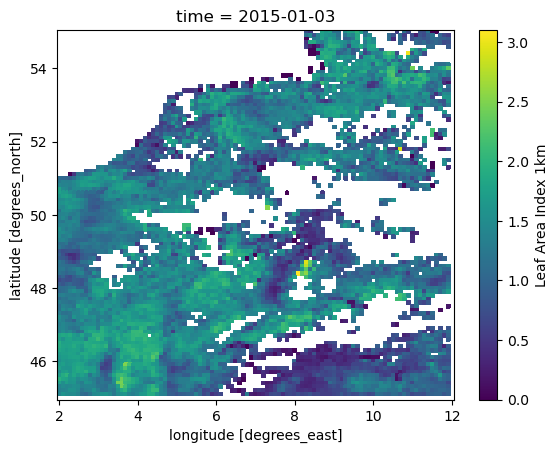

In [60]:
lai[0,:,:].plot()

In [61]:
### 2) read canopy height data
hc_path = inputData+year+'/canopy_height/mosaic_output10degree10km.tif'
hc = xr.open_dataset(hc_path, engine="rasterio").rename({'x':'longitude','y':'latitude'}).band_data

In [62]:
hc

<xarray.DataArray 'band_data' (band: 1, latitude: 101, longitude: 101)>
array([[[nan, nan, ...,  7., nan],
        [nan, nan, ...,  4., nan],
        ...,
        [20., 18., ...,  4., nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * longitude    (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 11.7 11.8 11.9 12.0
  * latitude     (latitude) float64 55.0 54.9 54.8 54.7 ... 45.3 45.2 45.1 45.0
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      band_data

In [63]:
### 3) read CO2 data
ds_co2 = xr.open_mfdataset(inputData+year+"/co2/CAMS_CO2_200*.nc", chunks="auto")['co2'].sel(time=year[:-6]).sel(latitude=slice(55, 50), longitude=slice(2, 7))
# convert unit: kg/kg to mg/m3
ds_co2 = vc.co2_mass_fraction_to_kg_per_m3(ds_co2)*1e6
# convert the longitude from [0, 360] to [-180, 180]
lon_name = 'longitude'
ds_co2['longitude_adjusted'] = xr.where(
    ds_co2[lon_name] > 180,
    ds_co2[lon_name] - 360,
    ds_co2[lon_name])
ds_co2 = (
    ds_co2
    .swap_dims({lon_name: 'longitude_adjusted'})
    .sel(**{'longitude_adjusted': sorted(ds_co2.longitude_adjusted)})
    .drop(lon_name))
ds_co2 = ds_co2.rename({'longitude_adjusted': lon_name})
ds_co2 = ds_co2.rio.write_crs('EPSG:4326')
era5 = era5.rio.write_crs('EPSG:4326')
ds_co2.rio.write_nodata(ds_co2.rio.nodata, inplace=True)
ds_co2_10km = ds_co2.rio.reproject_match(era5, resampling=Resampling.average)
ds_co2_10km = ds_co2_10km.assign_coords({
    "x": ds_co2_10km.x,
    "y": ds_co2_10km.y,
})
ds_co2_10km = ds_co2_10km.resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})
#CO2 has 1483 bands, ERA5-Land has 1487 bands. The end time is 21 and 23.
#Note, the time of ERA5-Land is ending time of every step, but CO2 is starting time of every step?
#2011-03-01T00:30:00.000000000 in ERA5-Land means 00:00-00:30, but in CO2 means 00:30-01:00？
ds_co2_10km=ds_co2_10km.assign_coords({'time':('time',ds_co2_10km.time.values + np.timedelta64(30,'m'),ds_co2_10km.time.attrs)})
#https://stackoverflow.com/questions/64737439/xarray-dataset-change-value-of-coordinates-while-keeping-attributes
# ds_co2_10km

In [64]:
ds_co2_10km

<xarray.DataArray 'co2' (time: 17515, latitude: 101, longitude: 101)>
array([[[7.97572021e+02, 7.97572021e+02, 7.97572021e+02, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [7.97572021e+02, 7.97572021e+02, 7.97572021e+02, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [7.97572021e+02, 7.97572021e+02, 7.97572021e+02, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        ...,
        [3.40282347e+38, 3.40282347e+38, 3.40282347e+38, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [3.40282347e+38, 3.40282347e+38, 3.40282347e+38, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [3.40282347e+38, 3.40282347e+38, 3.40282347e+38, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38]],

       [[7.97836792e+02, 7.97836792e+02, 7.97836792e+02, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [7.97836792e+02, 7.97836792e+02, 7.97836792e+02, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [7.97836792e+02, 7.97836792e+02, 7.97836792e+02, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
...
        [3.40282347e+38, 3.40282347e+38, 3.40282347e+38, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [3.40282347e+38, 3.40282347e+38, 3.40282347e+38, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [3.40282347e+38, 3.40282347e+38, 3.40282347e+38, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38]],

       [[7.96936401e+02, 7.96936401e+02, 7.96936401e+02, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [7.96936401e+02, 7.96936401e+02, 7.96936401e+02, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [7.96936401e+02, 7.96936401e+02, 7.96936401e+02, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        ...,
        [3.40282347e+38, 3.40282347e+38, 3.40282347e+38, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [3.40282347e+38, 3.40282347e+38, 3.40282347e+38, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [3.40282347e+38, 3.40282347e+38, 3.40282347e+38, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38]]])
Coordinates:
  * longitude    (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 11.7 11.8 11.9 12.0
  * latitude     (latitude) float32 55.0 54.9 54.8 54.7 ... 45.3 45.2 45.1 45.0
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2015-01-01T00:30:00 ... 2015-12-31T21:...
Attributes:
    _FillValue:  3.402823466e+38

In [65]:
## resampled CO2
# ds_co2_10km = xr.open_dataset(inputData+"/2017NL/co2/CAMS_CO2_2017_10km.nc")['co2'].sel(latitude=slice(55, 50), longitude=slice(2, 7)).resample(time="1800S").interpolate('linear')

In [66]:
### 4) read the resampled SSM data
## netcdf file works well
path_SSM = glob.glob(inputData+year+"/ssm/SM2015Europe11kmNL20230814_10km.nc")[0]
ds_SSM = xr.open_dataset(path_SSM)['__xarray_dataarray_variable__'].rename('SSM')
ds_SSM = ds_SSM.sortby(["longitude", "latitude"])
ds_SSM = ds_SSM.sel(longitude=slice(2,12), latitude=slice(45, 55))
SSM = ds_SSM.resample(time="1800S").interpolate('linear')/1000 

In [67]:
SSM

<xarray.DataArray 'SSM' (time: 17473, latitude: 101, longitude: 101)>
array([[[0.29378748, 0.29551263, 0.29395883, ..., 0.27835498,
         0.27380081, 0.27155969],
        [0.28524622, 0.29648206, 0.30026624, ..., 0.282728  ,
         0.26748383, 0.26148145],
        [0.28375861, 0.3032356 , 0.30546548, ..., 0.29299991,
         0.2745036 , 0.26550208],
        ...,
        [       nan,        nan,        nan, ..., 0.32845157,
         0.31261212, 0.30862283],
        [       nan,        nan,        nan, ..., 0.298     ,
         0.29100763, 0.284     ],
        [       nan,        nan,        nan, ..., 0.36      ,
         0.32903375, 0.298     ]],

       [[0.29407335, 0.29577782, 0.29420852, ..., 0.27835498,
         0.27382158, 0.27160127],
        [0.28557995, 0.29676887, 0.30057359, ..., 0.28269691,
         0.26747871, 0.26153357],
        [0.28394115, 0.30339201, 0.3056586 , ..., 0.292953  ,
         0.27447226, 0.26551262],
...
        [       nan,        nan,        nan, ..., 0.31457948,
         0.2994601 , 0.30274147],
        [       nan,        nan,        nan, ..., 0.28397917,
         0.27751746, 0.27104167],
        [       nan,        nan,        nan, ..., 0.3060625 ,
         0.27960174, 0.25308333]],

       [[0.28829691, 0.29177649, 0.30094394, ..., 0.2499465 ,
         0.25142317, 0.25393001],
        [0.2842207 , 0.29694742, 0.3080278 , ..., 0.25924796,
         0.26775314, 0.27149792],
        [0.2882612 , 0.31397675, 0.30971945, ..., 0.25899792,
         0.2602724 , 0.26154343],
        ...,
        [       nan,        nan,        nan, ..., 0.31446097,
         0.29935544, 0.30265793],
        [       nan,        nan,        nan, ..., 0.284     ,
         0.27750708, 0.271     ],
        [       nan,        nan,        nan, ..., 0.306     ,
         0.27952884, 0.253     ]]])
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 11.7 11.8 11.9 12.0
  * latitude   (latitude) float32 45.0 45.1 45.2 45.3 ... 54.7 54.8 54.9 55.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-12-31

In [68]:
### 5) read Vcmax data
ds_Vcmo = xr.open_rasterio(inputData+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc", engine="rasterio").rename({'x':'longitude','y':'latitude'})

/scratch-local/fnattino30.3957759/ipykernel_1400267/170410605.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_Vcmo = xr.open_rasterio(inputData+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc", engine="rasterio").rename({'x':'longitude','y':'latitude'})


In [69]:
ds_Vcmo = ds_Vcmo.sel(longitude=ds_ss.longitude, latitude=ds_ss.latitude, method='nearest', tolerance=0.01)

In [75]:
### 6) read IGBP data
# read lan
path_landcover = inputData+year+"/igbp/landcover10km_global.nc"
landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto").rename({'x':'longitude','y':'latitude'})
landcover = landcover.sel(longitude=ds_ss.longitude, latitude=ds_ss.latitude, method='nearest', tolerance=0.01)

/scratch-local/fnattino30.3957759/ipykernel_1400267/417659640.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto").rename({'x':'longitude','y':'latitude'})


In [76]:
# read IGBP unique values
data = pd.read_csv(inputData+'IGBP11unique.csv')['0'].unique()
# read the table for converting landcover to IGBP
IGBP_table = pd.read_csv(inputData+year+"/igbp/lccs_to_igbp_table.csv")

In [77]:
def landcover_to_igbp(landcover, IGBP_table, data):
    IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)(landcover.values)
    IGBP_all = pd.DataFrame(columns=['IGBP_veg_long1', 'IGBP_veg_long2', 'IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5',
                              'IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8','IGBP_veg_long9',
                             'IGBP_veg_long10','IGBP_veg_long11'])
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(categories=[data]*1,sparse=False,
                           handle_unknown = "ignore")
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[0]*IGBP.shape[1],1))
    # assign 23-D IGBP into 23 columns
    for i in range(1,12,1):
        IGBP_all['IGBP_veg_long'+str(i)] = aa[:,i-1]
    return IGBP_all

## 4) chunk all the input variables

In [78]:
ds_era5land = all_resample#.sel(time=t, method='nearest')#.compute()

ds_ss = xr.Dataset()
ds_ss["Rin"] = Rin.isel(time=slice(0,17000)).chunk({"latitude": 101, "longitude": 101})#.sel(time=t, method='nearest')#.compute()
ds_ss["Rli"] = Rli.isel(time=slice(0,17000)).chunk({"latitude": 101, "longitude": 101})#.sel(time=t, method='nearest')#.compute()
ds_ss["p"] = all_resample["sp"].chunk({"latitude": 101, "longitude": 101})/100   # Pa -> hPa
ds_ss["Ta"] = all_resample["t2m"].chunk({"latitude": 101, "longitude": 101}) - 273.15  # K -> degC
ds_ss["ea"] = vc.calculate_es(all_resample["d2m"] - 273.15).chunk({"latitude": 101, "longitude": 101})
ds_ss["u"] = (all_resample["u10"].chunk({"latitude": 101, "longitude": 101}) ** 2 + all_resample["v10"].chunk({"latitude": 101, "longitude": 101}) ** 2) ** 0.5
ds_ss["Precip_msr"] = all_resample["tp"].chunk({"latitude": 101, "longitude": 101})*1000   # mm
ds_ss['LAI'] = lai.chunk()#.sel(time=t, method='nearest')#.compute()
ds_ss['CO2'] = ds_co2_10km.chunk()#.sel(time=t, method='nearest')#.compute()
ds_ss['SSM'] = SSM.chunk()#.sel(time=t, method='nearest')#.compute()

ds_ss = ds_ss.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
ds_Vcmo = ds_Vcmo.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
landcover = landcover.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})

ds_ss = ds_ss.isel(time=slice(0,17000))


/gpfs/home2/fnattino30/mambaforge/envs/emulator/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/gpfs/home2/fnattino30/mambaforge/envs/emulator/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

In [79]:
ds_ss.nbytes/2**30

8.398500852286816

## 5) predict fluxes with map_blocks

In [80]:
ds_ss = ds_ss.to_array()

In [81]:
# ds_ss = ds_ss.chunk({"time":2000, "variable":10})

In [82]:
ds_ss = ds_ss.chunk({"time":2000, "variable":10, "latitude":51, "longitude":51})

In [83]:
hc=hc.chunk({"latitude":51, "longitude":51}).squeeze()
ds_Vcmo = ds_Vcmo.chunk({"latitude":51, "longitude":51}).squeeze()
landcover = landcover.chunk({"latitude":51, "longitude":51}).squeeze()

In [84]:
chunks = [ds_ss.chunksizes[v] for v in ['time', 'latitude', 'longitude']]
chunks.append((7,))

In [85]:
ds_ss = ds_ss.persist()
hc = hc.persist()
ds_Vcmo = ds_Vcmo.persist()
landcover = landcover.persist()

In [86]:
estimated_LEH = xr.DataArray(
    name = 'LEH',
    data=dask.array.zeros((len(ds_ss.time), len(ds_ss.latitude), len(ds_ss.longitude),7), chunks=chunks),
    dims=("time", "latitude", "longitude","variable_out"),
    coords={
        "variable_out":range(7), 
        "time":ds_ss.time, 
        "latitude":ds_ss.latitude,
        "longitude":ds_ss.longitude
    }
)

In [87]:
def predictFlux(ds_ss, hc, ds_Vcmo, landcover, IGBP_table, training_testing_append, path_model):
    # ds_ss = ds_ss.reshape(10,-1)
    # time = ds_ss.time
    # ds_ss = ds_ss.squeeze("time")
    hc = hc.sel(latitude=ds_ss.latitude, longitude=ds_ss.longitude)
    hc_line = np.tile(hc.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size) #如果和动态变量一样放进ds_ss里显示为一些离散的点，不知道为什么，所以静态变量放在时间循环外面
    print(hc_line.shape)
    ds_Vcmo = ds_Vcmo.sel(latitude=ds_ss.latitude, longitude=ds_ss.longitude)
    Vcmo_line = np.tile(ds_Vcmo.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    landcover = landcover.sel(latitude=ds_ss.latitude, longitude=ds_ss.longitude)
    IGBP_all = landcover_to_igbp(landcover, IGBP_table, training_testing_append)
    IGBP1 = np.tile(IGBP_all.iloc[:,0].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP2 = np.tile(IGBP_all.iloc[:,1].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP3 = np.tile(IGBP_all.iloc[:,2].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP4 = np.tile(IGBP_all.iloc[:,3].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP5 = np.tile(IGBP_all.iloc[:,4].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP6 = np.tile(IGBP_all.iloc[:,5].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP7 = np.tile(IGBP_all.iloc[:,6].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP8 = np.tile(IGBP_all.iloc[:,7].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP9 = np.tile(IGBP_all.iloc[:,8].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP10 = np.tile(IGBP_all.iloc[:,9].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP11 = np.tile(IGBP_all.iloc[:,10].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    
    
    Rin_line = ds_ss[0,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Rli_line = ds_ss[1,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    p_line = ds_ss[2,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Ta_line = ds_ss[3,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    ea_line = ds_ss[4,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    u_line = ds_ss[5,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Precip_msr_line = ds_ss[6,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    LAI_line = ds_ss[7,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    CO2_line = ds_ss[8,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    SSM_line = ds_ss[9,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)

    features_arr = np.concatenate((Rin_line, Rli_line, p_line, Ta_line,ea_line, u_line, Precip_msr_line,
                                   LAI_line, hc_line, CO2_line, SSM_line, Vcmo_line,
                                   IGBP1, IGBP2, IGBP3,IGBP4,IGBP5,IGBP6,IGBP7,IGBP8,IGBP9,IGBP10,IGBP11))
    features_arr = features_arr.transpose()
    # Nan value.
    df_features = pd.DataFrame(data=features_arr)
    df_features_drop_nan = df_features.dropna()
    invalid_index = sorted(set(df_features.index.to_list()) - set(df_features_drop_nan.index.to_list()))

    # # Convert the nan value as 0 for the calculation
    where_are_NaNs = np.isnan(features_arr)
    features_arr[where_are_NaNs] = 0
    
    model = load_model(path_model)
    
    # model = path_model
    estimated_LEH = model.predict(features_arr)
    estimated_LEH[invalid_index] = np.nan
    LEH_map = estimated_LEH.reshape(ds_ss.time.size, ds_ss.latitude.size, ds_ss.longitude.size,7)
    
    return xr.DataArray(
        name = 'LEH',
        data=LEH_map,
        dims=("time", "latitude", "longitude","variable_out"),
        coords={
            "variable_out":range(7), 
            "time":ds_ss.time, 
            "latitude":ds_ss.latitude,
            "longitude":ds_ss.longitude
        }
    )

In [88]:
result = xr.map_blocks(
    predictFlux,
    ds_ss,
    args=[hc, ds_Vcmo, landcover],
    kwargs={"IGBP_table":IGBP_table, "training_testing_append":data, "path_model":f'{workingPath}/3RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl'},
    template=estimated_LEH,
)

In [89]:
result

<xarray.DataArray 'LEH' (time: 17000, latitude: 101, longitude: 101,
                         variable_out: 7)>
dask.array<<this-array>-predictFlux, shape=(17000, 101, 101, 7), dtype=float64, chunksize=(2000, 51, 51, 7), chunktype=numpy.ndarray>
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-21T04...
  * latitude      (latitude) float64 55.0 54.9 54.8 54.7 ... 45.3 45.2 45.1 45.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 ... 11.7 11.8 11.9 12.0

In [91]:
result = result.persist()

In [90]:
# start_time = time.time()  # Record the start time
# result1 = result.compute()
# end_time = time.time()  # Record the end time
# total_running_time = end_time - start_time
# print("Total Running Time:", total_running_time)

In [92]:
result

<xarray.DataArray 'LEH' (time: 17000, latitude: 101, longitude: 101,
                         variable_out: 7)>
dask.array<<this-array>-predictFlux, shape=(17000, 101, 101, 7), dtype=float64, chunksize=(2000, 51, 51, 7), chunktype=numpy.ndarray>
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-21T04...
  * latitude      (latitude) float64 55.0 54.9 54.8 54.7 ... 45.3 45.2 45.1 45.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 ... 11.7 11.8 11.9 12.0

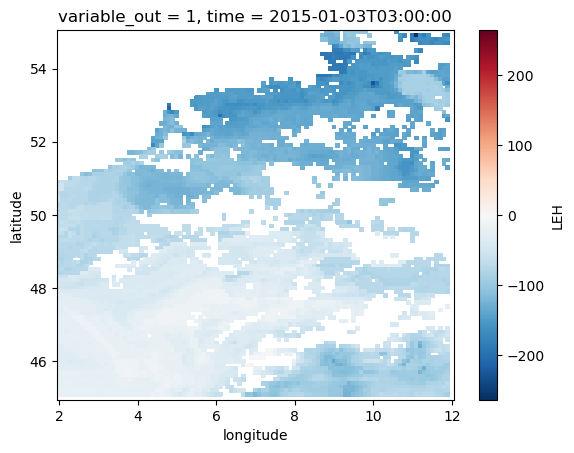

In [94]:
result[100,:,:,1].plot() 

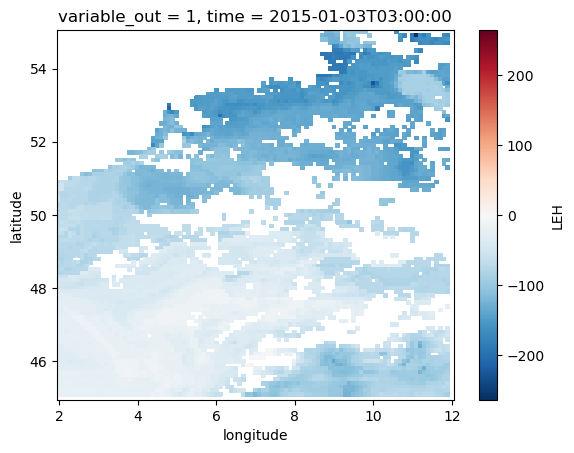

In [95]:
result[100,:,:,1].plot() 
## I read SSM geoTiff file in this run, so the longitude and latitude was not overlapped with other variables, 
## but I changed to resampled SSM netCDF file(I rerun the 2000 timesteps after this change), the result is normal now.

## export the result